In [ ]:
import torch
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
transform = transforms.Compose(
    [
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))]
)

In [ ]:
batch_size = 128

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 78592832.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

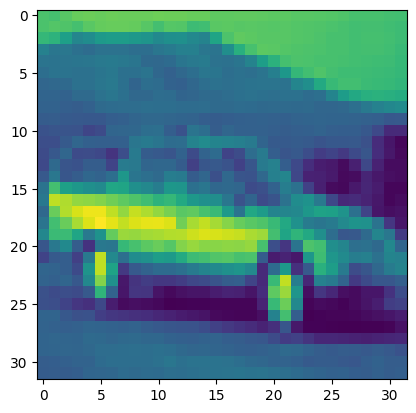

In [ ]:
image, label = train_dataset[4]

plt.imshow(image.permute(1, 2, 0))
plt.show()

In [ ]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500) # 4*4 так как изначально размер картинки 32*32 но после 3х сверточных слоев стало 4*4
    self.dropout1 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [ ]:
net = Net().cuda()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

In [ ]:
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.cuda()
      test_labels = test_labels.cuda()
      test_outputs = net(test_inputs)
      test_loss = loss_function(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size)
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  test_epoch_loss = test_running_loss/(len(test_loader)*batch_size)
  test_epoch_acc = test_running_corrects.float()/(len(test_loader)*batch_size)
  test_running_loss_history.append(test_epoch_loss)
  test_running_corrects_history.append(test_epoch_acc.cpu().numpy())

  print('epoch: ', e+1)
  print('training_loss: {:.4f}, acc: {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('test_loss: {:.4f}, test_acc: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch:  1
training_loss: 0.0156, acc: 0.2822 
test_loss: 0.0140, test_acc: 0.3622 
epoch:  2
training_loss: 0.0135, acc: 0.3787 
test_loss: 0.0131, test_acc: 0.3915 
epoch:  3
training_loss: 0.0128, acc: 0.4124 
test_loss: 0.0126, test_acc: 0.4217 
epoch:  4
training_loss: 0.0123, acc: 0.4363 
test_loss: 0.0122, test_acc: 0.4345 
epoch:  5
training_loss: 0.0119, acc: 0.4556 
test_loss: 0.0119, test_acc: 0.4483 
epoch:  6
training_loss: 0.0116, acc: 0.4708 
test_loss: 0.0115, test_acc: 0.4701 
epoch:  7
training_loss: 0.0113, acc: 0.4845 
test_loss: 0.0112, test_acc: 0.4841 
epoch:  8
training_loss: 0.0110, acc: 0.5009 
test_loss: 0.0110, test_acc: 0.5005 
epoch:  9
training_loss: 0.0108, acc: 0.5109 
test_loss: 0.0109, test_acc: 0.5018 
epoch:  10
training_loss: 0.0105, acc: 0.5217 
test_loss: 0.0107, test_acc: 0.5056 
epoch:  11
training_loss: 0.0103, acc: 0.5329 
test_loss: 0.0105, test_acc: 0.5239 
epoch:  12
training_loss: 0.0101, acc: 0.5432 
test_loss: 0.0104, test_acc: 0.5241 
e

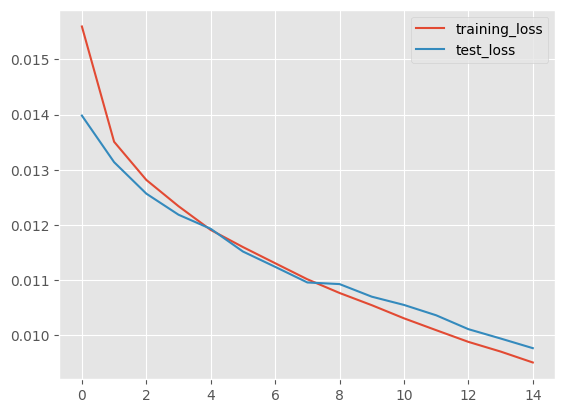

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training_loss')
plt.plot(test_running_loss_history, label = 'test_loss')
plt.legend()

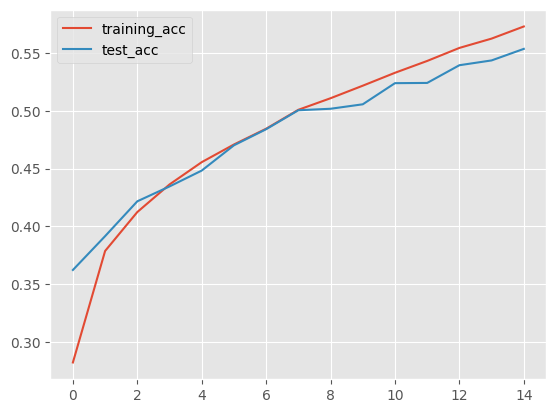

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training_acc')
plt.plot(test_running_corrects_history, label='test_acc')
plt.legend()

In [ ]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

for i in range(10):
  print("Accurace of %5s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

print()

Accurace of airplane : 55 %
Accurace of automobile : 70 %
Accurace of  bird : 19 %
Accurace of   cat : 19 %
Accurace of  deer : 43 %
Accurace of   dog : 54 %
Accurace of  frog : 75 %
Accurace of horse : 57 %
Accurace of  ship : 75 %
Accurace of truck : 65 %



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*128, 500)
        self.fc2 = nn.Linear(500, 256) # Добавлен полносвязный слой fc2
        self.dropout1 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 10) # Добавлен полносвязный слой fc3
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) # Добавлен полносвязный слой fc2
        x = self.dropout1(x)
        x = self.fc3(x) # Добавлен полносвязный слой fc3
        return F.log_softmax(x, dim=1)

In [ ]:
net = Net().cuda()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

In [ ]:
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.cuda()
      test_labels = test_labels.cuda()
      test_outputs = net(test_inputs)
      test_loss = loss_function(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size)
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  test_epoch_loss = test_running_loss/(len(test_loader)*batch_size)
  test_epoch_acc = test_running_corrects.float()/(len(test_loader)*batch_size)
  test_running_loss_history.append(test_epoch_loss)
  test_running_corrects_history.append(test_epoch_acc.cpu().numpy())

  print('epoch: ', e+1)
  print('training_loss: {:.4f}, acc: {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('test_loss: {:.4f}, test_acc: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch:  1
training_loss: 0.0157, acc: 0.2633 
test_loss: 0.0141, test_acc: 0.3398 
epoch:  2
training_loss: 0.0137, acc: 0.3565 
test_loss: 0.0132, test_acc: 0.3810 
epoch:  3
training_loss: 0.0130, acc: 0.3951 
test_loss: 0.0126, test_acc: 0.4055 
epoch:  4
training_loss: 0.0124, acc: 0.4200 
test_loss: 0.0123, test_acc: 0.4215 
epoch:  5
training_loss: 0.0121, acc: 0.4396 
test_loss: 0.0119, test_acc: 0.4364 
epoch:  6
training_loss: 0.0117, acc: 0.4590 
test_loss: 0.0116, test_acc: 0.4547 
epoch:  7
training_loss: 0.0114, acc: 0.4752 
test_loss: 0.0114, test_acc: 0.4696 
epoch:  8
training_loss: 0.0111, acc: 0.4899 
test_loss: 0.0110, test_acc: 0.4853 
epoch:  9
training_loss: 0.0108, acc: 0.5069 
test_loss: 0.0109, test_acc: 0.4928 
epoch:  10
training_loss: 0.0104, acc: 0.5218 
test_loss: 0.0110, test_acc: 0.4912 
epoch:  11
training_loss: 0.0102, acc: 0.5322 
test_loss: 0.0103, test_acc: 0.5201 
epoch:  12
training_loss: 0.0100, acc: 0.5450 
test_loss: 0.0102, test_acc: 0.5325 
e

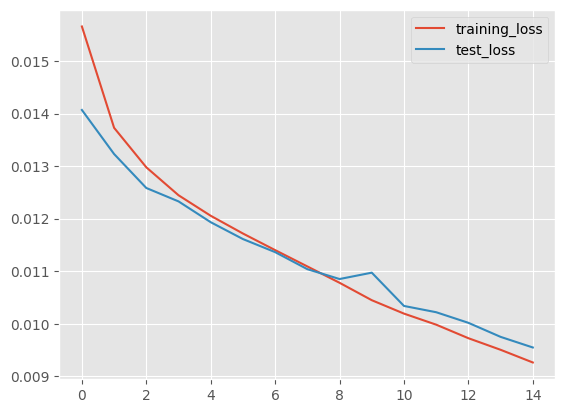

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training_loss')
plt.plot(test_running_loss_history, label = 'test_loss')
plt.legend()

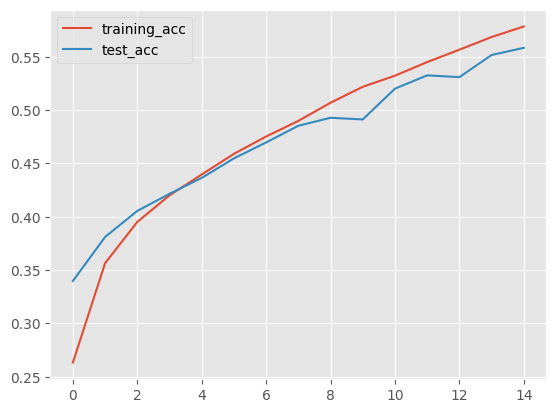

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training_acc')
plt.plot(test_running_corrects_history, label='test_acc')
plt.legend()

In [ ]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

for i in range(10):
  print("Accurace of %5s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

print()

Accurace of airplane : 47 %
Accurace of automobile : 88 %
Accurace of  bird : 30 %
Accurace of   cat : 44 %
Accurace of  deer : 39 %
Accurace of   dog : 57 %
Accurace of  frog : 83 %
Accurace of horse : 62 %
Accurace of  ship : 57 %
Accurace of truck : 60 %



In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(512, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 10)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x

In [ ]:
net = Net().cuda()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

In [ ]:
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.cuda()
      test_labels = test_labels.cuda()
      test_outputs = net(test_inputs)
      test_loss = loss_function(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size)
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  test_epoch_loss = test_running_loss/(len(test_loader)*batch_size)
  test_epoch_acc = test_running_corrects.float()/(len(test_loader)*batch_size)
  test_running_loss_history.append(test_epoch_loss)
  test_running_corrects_history.append(test_epoch_acc.cpu().numpy())

  print('epoch: ', e+1)
  print('training_loss: {:.4f}, acc: {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('test_loss: {:.4f}, test_acc: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch:  1
training_loss: 0.0108, acc: 0.4969 
test_loss: 0.0082, test_acc: 0.6288 
epoch:  2
training_loss: 0.0068, acc: 0.6998 
test_loss: 0.0066, test_acc: 0.6999 
epoch:  3
training_loss: 0.0051, acc: 0.7786 
test_loss: 0.0059, test_acc: 0.7443 
epoch:  4
training_loss: 0.0039, acc: 0.8303 
test_loss: 0.0060, test_acc: 0.7472 
epoch:  5
training_loss: 0.0029, acc: 0.8735 
test_loss: 0.0061, test_acc: 0.7537 
epoch:  6
training_loss: 0.0022, acc: 0.9054 
test_loss: 0.0062, test_acc: 0.7616 
epoch:  7
training_loss: 0.0017, acc: 0.9279 
test_loss: 0.0062, test_acc: 0.7667 
epoch:  8
training_loss: 0.0013, acc: 0.9449 
test_loss: 0.0070, test_acc: 0.7688 
epoch:  9
training_loss: 0.0011, acc: 0.9524 
test_loss: 0.0069, test_acc: 0.7732 
epoch:  10
training_loss: 0.0009, acc: 0.9634 
test_loss: 0.0072, test_acc: 0.7708 
epoch:  11
training_loss: 0.0008, acc: 0.9652 
test_loss: 0.0074, test_acc: 0.7732 
epoch:  12
training_loss: 0.0007, acc: 0.9698 
test_loss: 0.0078, test_acc: 0.7761 
e

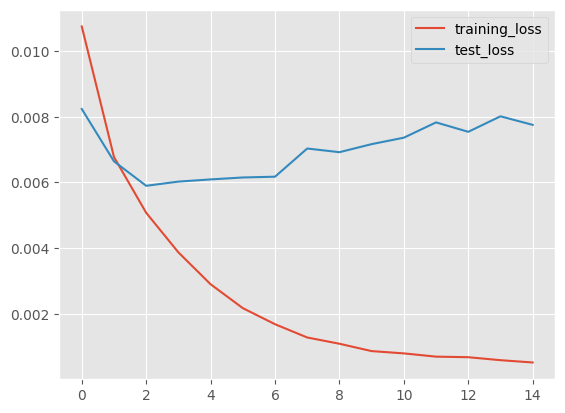

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training_loss')
plt.plot(test_running_loss_history, label = 'test_loss')
plt.legend()

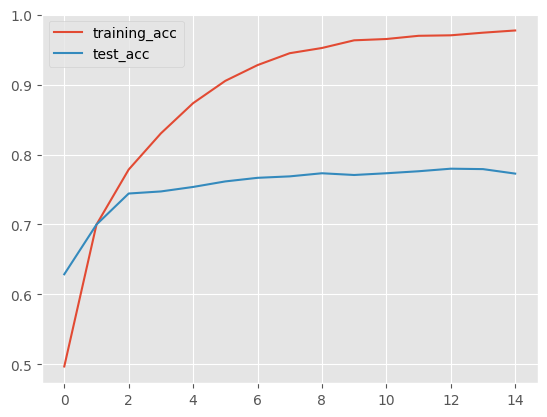

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training_acc')
plt.plot(test_running_corrects_history, label='test_acc')
plt.legend()

In [ ]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

for i in range(10):
  print("Accurace of %5s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

print()

Accurace of airplane : 75 %
Accurace of automobile : 91 %
Accurace of  bird : 56 %
Accurace of   cat : 60 %
Accurace of  deer : 76 %
Accurace of   dog : 62 %
Accurace of  frog : 83 %
Accurace of horse : 75 %
Accurace of  ship : 82 %
Accurace of truck : 79 %

